<font size="+2">
Reconstruction using pre-tained model
</font>

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import os, cv2, time, hdf5storage

import models.dataset as ds
import helper as hp

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda:0'

<font size="+1">
Load PSFs and pre-tained model
</font>

In [2]:
psf_file='./sample_data/psf5_2048.mat'
model_filepath='./trained_data/'
model, args = hp.load_model(psf_file, model_filepath, device = device)

<font size="+1">
Cropping parameters
</font>

In [3]:
image_height_org = 2048
image_width_org = 2048
image_height_crop = 1536
image_width_crop = 1536
image_shift_height = -56
image_shift_width = -56

target_height = 768
target_width = 768

<font size="+1">
Load measurements
</font>

Simulated measurements are .png files, real measurements are .mat files

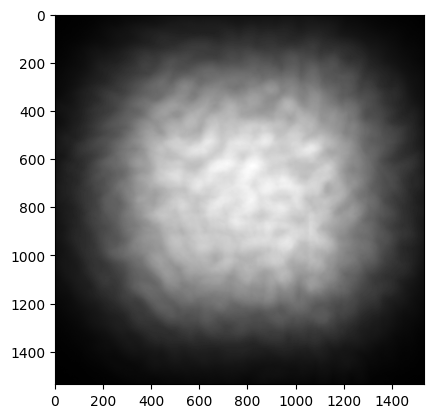

In [4]:
measurement_type = 0 # 0 for simulated measurement, 1 for real measurement

if measurement_type == 0: # simulated measurement
    loaded_meas = ('./sample_data/simulated/0004.png')
    meas_loaded = cv2.imread(loaded_meas)/255.0
    meas=meas_loaded[:,:,1]
    
else: # real meaturement
    loaded_meas = ('./sample_data/real/convallaria_cap_1.56mm.mat')
    meas_loaded = hdf5storage.loadmat(loaded_meas)['avgCap']
    meas=meas_loaded[:,513:2560]

measurement = hp.crop_images(meas, image_height_org, image_width_org, image_height_crop, image_width_crop, image_shift_height, image_shift_width)

#meas[crop_x_start:crop_x_end,crop_y_start:crop_y_end]

plt.imshow(measurement, cmap='gray')

<font size="+1">
Run reconstruction
</font>

In [5]:
measurement_tensor=torch.tensor(measurement, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
out = model((measurement_tensor).to(device))
output_numpy = out.detach().cpu().numpy()[0][0]
del out

output_numpy = hp.crop_out_single(output_numpy, target_height, target_width, image_shift_height, image_shift_width)
output_numpy[output_numpy <= 0] = 0
output_numpy = (output_numpy-output_numpy.min())/(output_numpy.max()-output_numpy.min())

torch.cuda.empty_cache() 

<font size="+1">
Display & save results
</font>

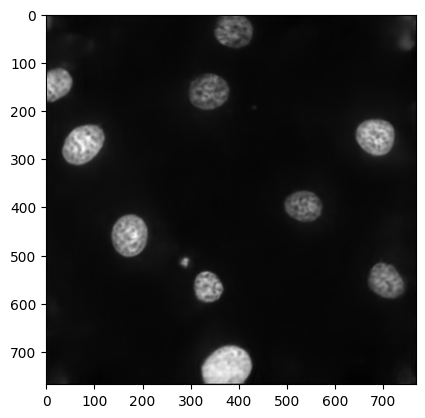

In [6]:
plt.imshow(output_numpy,cmap='gray')

out_dir = './recon/'
outname = [out_dir, '0005.png']
plt.imsave("".join(outname), output_numpy, cmap='gray')